In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

train_data = pd.read_csv('news-train.csv')
test_data = pd.read_csv('news-test.csv')
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

### Preprocessing

In [2]:
stemmer = PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

with open('dictionary.txt') as f:
    dic = f.read().splitlines()


def get_tokens(text):

    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation_map)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed


tokenized = [get_tokens(text) for text in train_data['Text']]

def get_dic_words(text): 
	cleaned = []
	for word in text:
		if word in dic:
			cleaned.append(word)
	return " ".join(str(word) for word in cleaned)

tokenized = [get_dic_words(text) for text in tokenized]

print(tokenized[:1])

['new yuko owner russia oil firm sold sunday specul financ group emerg winner agre pay russia newspap claim front expect win sale yuko owner said sold best author made christma present russia oil compani news agenc mr say via lawyer expect win thought fail get financ deal us court take part last week yuko file 11 bankruptci protect us attempt account us judg ban take part intern bank provid firm cash financ said analyst money around deni behind front said analyst know compani link 100 tri find far know paper result sale howev bought time rais money need analyst said one pay two week time put back hand back within reach yuko plan let go unit without fight legal action yuko main sharehold group also legal action yuko claim polit face fraud charg hit tax fine mani say break firm account 20 russia oil']


### Create a new csv file that contains cleaned text from original train data

In [3]:
# Save to a new file
train_df = pd.DataFrame({'ArticleId': train_data['ArticleId'], 'Text': tokenized, 'Category': train_data['Category']})
train_df.to_csv('news-train-cleaned.csv', index=False)

# re-assign train data to the new cleaned data
train_data_X = train_df['Text']
train_data_Y = train_df['Category']

### Q2 

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_Y = encoder.fit_transform(train_data_Y)

from zeugma import EmbeddingTransformer

glove = EmbeddingTransformer('glove-wiki-gigaword-100')
glove_embedding= glove.fit_transform(train_data_X)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

svc_params = {
	'svc__C': range(1,101,5),
	'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(pipe, svc_params, cv=5)
grid_search.fit(glove_embedding, train_Y)
best_params = grid_search.best_params_
print(best_params)

{'svc__C': 11, 'svc__kernel': 'rbf'}


C=1, kernel=rbf 	  Avg. Training Accuracy: 0.9726510067114094 	 Training Std. Deviation: 0.002408171156779741
C=1, kernel=rbf 	  Avg. Validation Accuracy: 0.94496644295302 	 Validation Std. Deviation: 0.012302216630753954


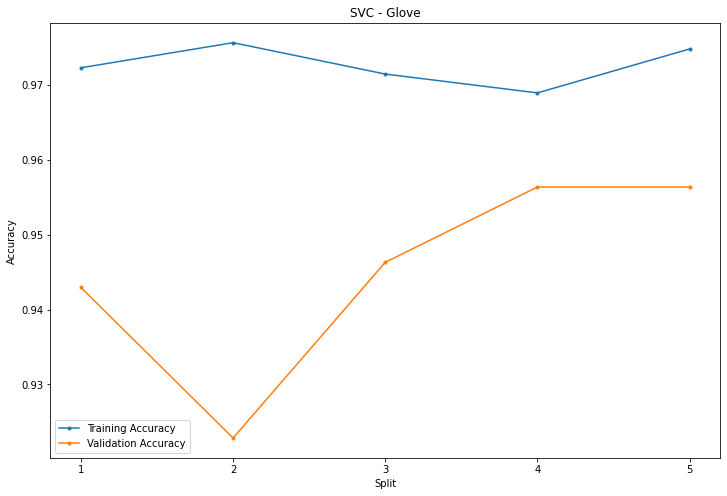

In [6]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
train_acc = []
val_acc = []
for train, test in kf.split(glove_embedding):
	x = glove_embedding[train, :]
	y = train_Y[train]

	x_val = glove_embedding[test,:]
	y_val = train_Y[test]

	svc = SVC(C=best_params['svc__C'], kernel=best_params['svc__kernel'])
	svc.fit(x,y)
	train_acc.append(svc.score(x,y))
	val_acc.append(svc.score(x_val,y_val))

print(
	f'C=1, kernel=rbf \t  Avg. Training Accuracy: {np.mean(train_acc)} \t Training Std. Deviation: {np.std(train_acc)}')
print(
    f'C=1, kernel=rbf \t  Avg. Validation Accuracy: {np.mean(val_acc)} \t Validation Std. Deviation: {np.std(val_acc)}')
plt.figure(figsize=(12, 8))
plt.plot(range(1, 6), train_acc, marker='.', label='Training Accuracy')
plt.plot(range(1, 6), val_acc, marker='.', label='Validation Accuracy')
plt.xlabel('Split')
plt.xticks(range(1, 6))
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'SVC - Glove')
plt.show()


### Q3 

In [7]:
# Train model w/ best params from GridSearch
svc = SVC(C=best_params['svc__C'], kernel=best_params['svc__kernel'])
svc.fit(glove_embedding, train_Y)

# Get vectors for test data
test_glove = glove.transform(test_data['Text'])

# Predict
prediction = svc.predict(test_glove)

# Get the labels
pred_labels = encoder.inverse_transform(prediction)

# Save to file
pred_df = pd.DataFrame()
pred_df['ArticleId'] = test_data['ArticleId']
pred_df['Category'] = pred_labels
pred_df.to_csv('labels.csv', index=False, header=False)